<a href="https://colab.research.google.com/github/hui509/Prediction-of-quality-of-Wine/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C%EF%BD%9C%E7%B4%85%E9%85%92%E5%93%81%E8%B3%AA%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **專題實作｜紅酒品質預測**

# 目標：利用現有資料集訓練一個有效的模型，協助判斷紅酒品質好壞。

# **載入 `Red Wine Quality` 資料集**



In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv')
df

# **資料概況**

**1. Red Wine Quality 各欄位定義**

* fixed acidity : 非揮發性酸
* volatile acidity : 揮發性酸
* citric acid : 檸檬酸
* residual sugar : 殘留糖分
* chlorides : 氯化物
* free sulfur dioxide : 游離二氧化硫
* total sulfur dioxide : 總二氧化硫
* density : 密度
* pH : pH值
* sulphates : 硫酸鹽
* alcohol : 酒精濃度
* qulity : 品質 (分數介於0 - 10)


**2. 觀察每個「特徵」欄位（除 quality 外）資料的分佈情況**

* 品質越好的紅酒，檸檬酸(citric acid)、硫酸鹽(sulphates)越高。
* 品質越好的紅酒，揮發性酸度(volatile acidity)、氯化物(chlorides)越少。
* 密度(density)對紅酒品質不具有區別性，皆大約為1。
* pH值對紅酒品質區別性也很小，大約落在3左右。




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# 創建一個3x4的圖
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

# 將axes攤平為一維矩陣，以利後續遍歷
axes = axes.flatten()

# 定義資料欄位的索引
column_index = 0

# 長條圖呈現各特徵的分布
for i in df.columns:
  if i != 'quality':
    sns.barplot(data=df, x='quality', y=i, palette='coolwarm', ax=axes[column_index])
    axes[column_index].set_title(i)
    column_index += 1

# 刪除最後一個空白圖表
axes[-1].remove()

# 調整子圖之間的間距
plt.tight_layout()

# 輸出圖表
plt.show()

**3. 觀察每個「標籤」欄位（quality）資料的分佈情況**

* 資料中的 quality 介於3-8分之間。
* 獲得5、6分 quality 的紅酒占多數，共有1319筆，呈現不平衡情況


In [ ]:
# 計算不同quality的筆數
df['quality'].value_counts()

In [ ]:
# 計數圖呈現quality的分布
sns.countplot(data=df, x='quality', palette='coolwarm')

**4. 觀察各特徵之間的關係**

* Pearson 相關分析中，小於0.3為低相關，介於0.3~0.7為中等相關，大於0.7為高度相關
* 酒精濃度(alcohol)與紅酒品質有(0.48)的相關性，有較高的正相關。
* 揮發性酸度(volatile acidity)與紅酒品質有(-0.39)的相關性，有較高的負相關。



In [ ]:
# 計算相關性
cor = df.corr()

# 使用seaborn和matplotlib，視覺化呈現
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,linewidth=0.5,cmap='coolwarm')
plt.title('Correlation Matrix of Red Wine Quality')
plt.show()

# **資料處理**

**1. 資料清理與型態轉換**

* 資料中沒有缺失值，無須進行填補。
* 資料中除quality欄位為int型態，其餘為float型態，皆可投入模型。



In [ ]:
# 確認是否有缺失值
df.isnull().sum()

In [ ]:
# 確認資料型態是否符合模型需求
df.info()

**2. 處理標籤欄位(quality)**

* 原始quality介於3-8分，依據分數無法直接判斷「好或壞」，且存在資料不平衡。
* 二元分類quality並進行型態轉換，區分為good(1)、bad(0)，結果依舊存在資料不平衡。

In [47]:
# 以6.5分為基準，將quality分為good和bad
bins = (0, 6.5, 10)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [48]:
# 型態轉換：quality原為有序數值，故使用Labelencoder將good轉為1，bad轉為0
from sklearn.preprocessing import LabelEncoder
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

In [ ]:
# 計數圖呈現分類後的quality分布
sns.countplot(data=df, x='quality', palette='coolwarm')

**3. 特徵工程**

* 以 Standardize 正規化調整 quality 欄位資料差距大的情況


In [50]:
# 資料正規化 - Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_columns = df.columns.difference(["quality"])
df[feature_columns] = scaler.fit_transform(df[feature_columns])


# **模型分析**

**1. 使用少數類過採樣技術(SMOTE)方法，處理資料不平衡問題**

**2. 採用 scikit-learn 五種基本模型進行分析與比較**

* 邏輯回歸 Logistic Regression
* 支持向量機 Support Vector Machines
* 決策樹 Decision Tree Classifier
* 隨機森林 Random Forest Classifier
* K-近鄰演算法 K Nearest Neighbor


In [51]:
# 載入模型
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [52]:
# 拆分訓練集與測試集
X = df.drop('quality', axis = 1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 43, stratify=y_train)

# 使用SMOTE，處理資料不平衡問題
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [53]:
# Scikit-learn 五種基本模型分析
models = {
    'Logistic Regression':LogisticRegression(random_state=0,max_iter=3000),
    'SVC':SVC(),
    'Decision Tree Classifer':DecisionTreeClassifier(),
    'Random Forest Classifer':RandomForestClassifier(),
    'KNN':KNeighborsClassifier()
      }
scores = [ ]
for model_name,model in models.items():
  score = cross_val_score(model,X_train_resampled,y_train_resampled.values.ravel(),cv=5,scoring='accuracy').mean()
  scores.append({'model':model_name, 'accuracy':score})

# **模型優化**

**1. 使用 GridSearchCV( ) 調整參數**




In [54]:
# 超參數調整
from sklearn.model_selection import GridSearchCV
model_params = {
  'Logistic Regression(Opt)':{
      'model':LogisticRegression(),
      'params':{'C': [0.01, 0.1, 1, 10],'solver': ['liblinear','lbfgs']}
              },
  'SVC(Opt)':{
      'model':SVC(),
      'params':{'C':[0.1,1,10],'kernel':['rbf'],'gamma':[0.05, 0.1]}
      },
  'Decision Tree Classifier(Opt)':{
      'model':DecisionTreeClassifier(),
      'params':{'criterion': ['gini', 'entropy'],'max_depth': [4, 6, 8],
            'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
          },
  'Random Forest Classifier(Opt)':{
      'model':RandomForestClassifier(),
      'params':{'n_estimators': [10, 50],'max_depth': [4, 6, 8],'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt']}
          },
  'KNN(Opt)':{
      'model':KNeighborsClassifier(),
      'params':{'n_neighbors': [3, 5, 7, 9],'weights': ['uniform', 'distance']}
      }
  }

scores_opt = []
for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'],mp['params'],cv=5)
  score = cross_val_score(mp['model'],X_train_resampled,y_train_resampled.values.ravel(),cv=5,scoring='accuracy').mean()
  scores_opt.append({'model':model_name,'accuracy':score})

In [55]:
# 比較超參數調整前後結果
combined = scores + scores_opt
df = pd.DataFrame(combined)
df.sort_values(by='accuracy',ascending=False)

,model,accuracy
8,Random Forest Classifier(Opt),0.942891
3,Random Forest Classifer,0.942886
2,Decision Tree Classifer,0.897805
7,Decision Tree Classifier(Opt),0.896301
4,KNN,0.879763
9,KNN(Opt),0.879763
1,SVC,0.866736
6,SVC(Opt),0.866736
0,Logistic Regression,0.804610
5,Logistic Regression(Opt),0.804610


**2. 使用PyTorch模型進行分析**

In [56]:
# PyTorch
import torch
import numpy as np

# 創建模型架構
class Model(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, 64)
        self.hidden2 = torch.nn.Linear(64, 32)
        self.predict = torch.nn.Linear(32, output_size)

    def forward(self, x):
        output1 = torch.relu(self.hidden1(x))
        output2 = torch.relu(self.hidden2(output1))
        output = torch.sigmoid(self.predict(output2))
        return output

# 模型、優化器初始化
model = Model(X_test.shape[1], 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.0) # 模型參數優化器
loss_func = torch.nn.BCELoss()


# 資料格式轉成torch專用格式
x_data = torch.tensor(X_train.values, dtype=torch.float32)
y_data = torch.tensor(np.expand_dims(y_train, axis=1), dtype=torch.float32)

x_val_data = torch.tensor(X_val.values, dtype=torch.float32)
y_val_data = torch.tensor(np.expand_dims(y_val, axis=1), dtype=torch.float32)

x_test_data = torch.tensor(X_test.values, dtype=torch.float32)
y_test_data = torch.tensor(np.expand_dims(y_test, axis=1), dtype=torch.float32)

batch_size = 32
num_epochs = 200

training_losses = []
val_losses = []

for epoch in range(num_epochs):
    for i in range(0, len(x_data), batch_size):
        prediction = model(x_data[i:i+batch_size])
        loss = loss_func(prediction, y_data[i:i+batch_size])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss_func(model(x_data), y_data)
    training_losses.append(float(loss))

    y_pred = model(x_val_data)
    val_loss = loss_func(y_pred, y_val_data)
    print("training loss:{}, val loss:{}, val acc:{}".format(float(loss), val_loss, accuracy_score(y_val_data, np.where(y_pred >= 0.5, 1, 0))))

    val_losses.append(float(val_loss))

training loss:0.41587892174720764, val loss:0.42474183440208435, val acc:0.8671875
training loss:0.3560630977153778, val loss:0.3740205764770508, val acc:0.8671875
training loss:0.32782530784606934, val loss:0.35182178020477295, val acc:0.8671875
training loss:0.30868738889694214, val loss:0.3377566635608673, val acc:0.8671875
training loss:0.2953042685985565, val loss:0.32889583706855774, val acc:0.8671875
training loss:0.28596031665802, val loss:0.32398465275764465, val acc:0.8671875
training loss:0.27941519021987915, val loss:0.3222762942314148, val acc:0.875
training loss:0.2746477425098419, val loss:0.321912944316864, val acc:0.8828125
training loss:0.2709384560585022, val loss:0.32208067178726196, val acc:0.8671875
training loss:0.26801028847694397, val loss:0.3228211998939514, val acc:0.8671875
training loss:0.2656293213367462, val loss:0.3237479329109192, val acc:0.8515625
training loss:0.2635529637336731, val loss:0.32467296719551086, val acc:0.84375
training loss:0.2616851925

In [57]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = model(x_test_data)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       273
           1       0.57      0.60      0.58        47

    accuracy                           0.88       320
   macro avg       0.75      0.76      0.75       320
weighted avg       0.88      0.88      0.88       320



Text(0, 0.5, 'loss')

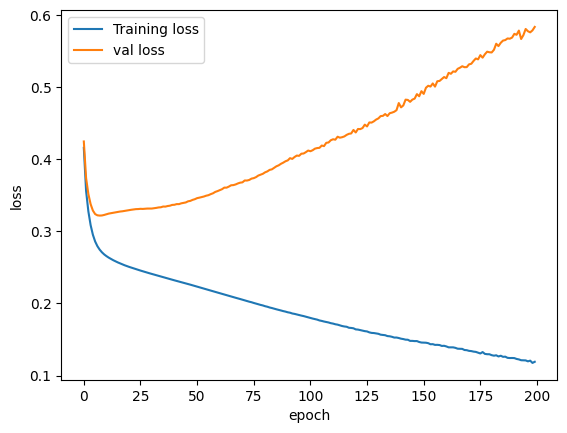

In [58]:
# 視覺化呈現結果
plt.plot(training_losses)
plt.plot(val_losses)
plt.legend(("Training loss", "val loss"))
plt.xlabel("epoch")
plt.ylabel("loss")